<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-04-01-multilevel-random-intercept-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 1. Random Intercept Model

Mixed-effects models, particularly Random Intercept Models, are vital for analyzing hierarchical data, like students in classes. This tutorial covers 1. **Understanding Random Intercept Models**: Definitions, uses, and contexts. 2. **Model Construction**: Building from basic principles. 3. **Fitting in R**: Using {lme4} and {nlme} packages. 4. **Interpreting Results**: Analyzing outputs and fit metrics. By the end, you'll confidently apply and interpret Random Intercept Models.


## Overview

**random intercept model** is a type of **mixed-effects model** where the intercept (baseline level) of the outcome variable is allowed to vary across groups, while the slope (relationship between the predictors and outcome) remains constant across groups.

For an observation $y_{ij}$, where $i$ indexes the group (e.g., schools) and $j$ indexes the individual (e.g., students within a school):

$$ y_{ij} = \beta_0 + \beta_1 x_{ij} + u_i + \epsilon_{ij} $$

Where:

-   $y_{ij}$: Outcome for the $j$-th individual in the $i$-th group.

-   $\beta_0$: Fixed intercept (average baseline outcome across all groups).

-   $\beta_1$: Fixed slope (effect of predictor $x$ on $y$).

-   $x_{ij}$: Predictor variable for the $j$-th individual in the $i$-th group.

-   $u_i$: **Random intercept**, representing the deviation of the $i$-th group’s intercept from the overall average $\beta_0$. Assumed to follow $u_i \sim N(0, \sigma_u^2)$.

-   $\epsilon_{ij}$: Residual error for the $j$-th individual in the $i$-th group. Assumed to follow $\epsilon_{ij} \sim N(0, \sigma_\epsilon^2)$.

### Key Features

1.  **Intercept Varies by Group**:

    -   Each group $i$ has its own intercept:

        $$  \beta_0^i = \beta_0 + u_i $$

    $u_i$ is the random effect for group $i$, capturing group-specific deviations.

2.  **Slope Remains Constant**:

    -   The relationship between $x_{ij}$ and $y_{ij}$(slope $\beta_1$) is the same across all groups.

3.  **Variance Decomposition**:

    -   Total variance is partitioned into:

        -   **Between-group variance**: Variance of the random intercepts (\$ \sigma\_u\^2\$).
        -   **Within-group variance**: Variance of residuals ($\sigma_\epsilon^2$).

### Example

We want to model students' test scores $y$ as a function of their study hours $x$, accounting for differences between schools.

$$ y_{ij} = \beta_0 + \beta_1 x_{ij} + u_i + \epsilon_{ij} $$

-   $\beta_0$: Average baseline test score across all schools.

-   $u_i$: Random intercept capturing school-specific effects.

-   $epsilon_{ij}$: Student-level random noise.

#### Estimation

1.  **Fixed Effects**:

    -   $\beta_0$: Average baseline score for all schools.

    -   $\beta_1$: Average effect of study hours on test scores (slope).

2.  **Random Effects**:

    -   $u_i$: Captures the deviation of each school's baseline score from the overall average $\beta_0$.

    -   For example:

        -   School A might have a $u_i > 0$ (higher baseline scores).

        -   School B might have a $u_i < 0$ (lower baseline scores).

#### Intraclass Correlation Coefficient (ICC)

The ICC measures the proportion of variance explained by the grouping structure (e.g., schools):

$$ \text{ICC} = \frac{\sigma_u^2}{\sigma_u^2 + \sigma_\epsilon^2} $$

-   High ICC ($\text{ICC} \approx 1 $): Large between-group variability (schools strongly affect scores).

-   Low ICC ($\text{ICC} \approx 0 $): Most variability is at the individual level.

## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314975 sha256=eabc1ce4ff8c085dc6fe4990750ac0904037ba455fe5ff8fbbe5177a4d00f5eb
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Random Intercept Model from Scratch

To fit a Random Intercept Model in R from scratch without relying on any external R packages, you need to manually calculate the model parameters using Maximum Likelihood Estimation (MLE) or some iterative process like Expectation-Maximization (EM). Here's how you could do it:

### Simulate the data

First we create  dataset with variables `score`, `hours`, and `school`. `score` is the outcome variable, `hours` is the predictor, and `school` is the grouping variable. We also generate random effects for each school and fixed effects for the intercept and hours.

In [3]:
%%R
# Step 1: Simulate Data
set.seed(42)
n_schools <- 10    # Number of schools
n_students <- 50   # Students per school

# Random effects
schools <- rep(1:n_schools, each = n_students)
u <- rnorm(n_schools, mean = 0, sd = 5)  # Random intercept for schools

# Fixed effects
beta_0 <- 50     # Intercept
beta_1 <- 2      # Coefficient for hours
hours <- rnorm(n_schools * n_students, mean = 5, sd = 2)

# Residual error
epsilon <- rnorm(n_schools * n_students, mean = 0, sd = 3)

# Outcome variable
score <- beta_0 + beta_1 * hours + u[schools] + epsilon

### Define the REML Log-Likelihood Function

The log-likelihood function calculates the negative log-likelihood of the model parameters given the data. Here, we use a block-diagonal approach to handle the school-specific random effects efficiently. `Cholesky Decomposition` is used to compute the log-determinant of the block covariance matrices to avoids directly computing $det(V)$, which can be numerically unstable.

The total variance-covariance matrix $V$ is block-diagonal because observations are grouped by schools. Each block $V_k$ for school $k$ has the form:

$$ V_k = \sigma_u^2 J_k + \sigma_e^2 I_k $$

where:

-   $J_k$: matrix of ones ($n_k \times n_k$),
-   $I_k$: identity matrix ($n_k \times n_k$),
-   $\sigma_u^2$: variance of random intercepts,
-   $\sigma_e^2$: residual variance.

For $n_k$ students in school $k$, $V_k$ is a $n_k \times n_k$ matrix that captures the correlation structure due to the random intercept.

-   The block-diagonal structure of $V$ ensures that:

    -   **Matrix inversion** and **determinant computation** are done for smaller blocks ($V_k$) instead of the full $V$, reducing computational complexity.
    -   For $n_schools$ blocks and average block size $n_k$, complexity scales as $O(n_schools \cdot n_k^3)$ instead of $O(n^3)$ for the full matrix.

The log-likelihood for the multivariate normal distribution of residuals is:

$$ \ell = -\frac{1}{2} \left[ \log(\det(V)) + \mathbf{r}^\top V^{-1} \mathbf{r} \right] $$

where:

-   $\mathbf{r} = \mathbf{y} - \mathbf{X} \boldsymbol{\beta}$ is the vector of residuals,
-   $\boldsymbol{\beta} = [\beta_0, \beta_1]^\top$,
-   $\mathbf{X}$: design matrix ($n \times 2$) with columns of ones and $x_{ij}$,
-   ( V ): block-diagonal variance-covariance matrix.

Since $V$ is block-diagonal, we can compute $\log(\det(V))$ and $\mathbf{r}^\top V^{-1} \mathbf{r}$ efficiently for each block $V_k$ independently.

Following are the steps to implement the log-likelihood function:


In [4]:
%%R
# Step 2: Define the REML log-likelihood function (block-diagonal version)
reml_loglik <- function(params) {
  # Ensure positivity with exponential transform
  sigma_u <- exp(params[1])  # Random intercept variance
  sigma_e <- exp(params[2])  # Residual variance
  beta_0 <- params[3]        # Fixed intercept
  beta_1 <- params[4]        # Fixed slope

  # Design matrix and fixed effects
  X <- cbind(1, hours)
  beta <- c(beta_0, beta_1)
  residuals <- score - X %*% beta

  # Initialize log-likelihood components
  log_det_sum <- 0
  quad_form_sum <- 0

  # Loop through schools to process blocks
  for (k in 1:n_schools) {
    # Get data for school k
    idx <- (1:n_students) + (k - 1) * n_students
    n_k <- length(idx)
    residuals_k <- residuals[idx]

    # Block covariance matrix for school k
    J_k <- matrix(1, n_k, n_k)  # All-ones matrix
    I_k <- diag(n_k)            # Identity matrix
    V_k <- sigma_u^2 * J_k + sigma_e^2 * I_k

    # Compute log-determinant using Cholesky
    chol_decomp <- tryCatch(chol(V_k), error = function(e) NULL)
    if (is.null(chol_decomp)) {
      cat("Cholesky decomposition failed for school", k, "sigma_u =", sigma_u, "sigma_e =", sigma_e, "\n")
      return(Inf)
    }
    log_det_V_k <- 2 * sum(log(diag(chol_decomp)))

    # Compute quadratic form
    quad_form_k <- t(residuals_k) %*% solve(V_k, residuals_k)

    # Accumulate results
    log_det_sum <- log_det_sum + log_det_V_k
    quad_form_sum <- quad_form_sum + quad_form_k
  }

  # Log-likelihood
  ll <- -0.5 * (log_det_sum + quad_form_sum)

  # Penalize non-finite likelihood
  if (!is.finite(ll)) {
    cat("Non-finite likelihood: sigma_u =", sigma_u, "sigma_e =", sigma_e, "\n")
    return(Inf)
  }

  return(as.numeric(-ll)) # Minimization
}



### Optimization with Bounds

Optimization is performed using the `optim()` function with bounds on the parameters to ensure positivity. We log-transform the variance components to ensure they remain positive during optimization. The method `L-BFGS-B` is used for optimization. The initial guesses and bounds are set for the parameters.     



In [5]:
%%R
# Step 3: Optimization with bounds
initial_params <- c(log(1), log(1), 50, 2) # Log-transformed initial guesses
lower_bounds <- c(log(1e-6), log(1e-6), -Inf, -Inf) # Avoid zero variance
upper_bounds <- c(log(1e3), log(1e3), Inf, Inf)

result <- optim(initial_params, reml_loglik, method = "L-BFGS-B",
                lower = lower_bounds, upper = upper_bounds, control = list(maxit = 1000))

# Transform back to original scale
sigma_u_est <- exp(result$par[1])
sigma_e_est <- exp(result$par[2])
beta_0_est <- result$par[3]
beta_1_est <- result$par[4]


### Summary of Model Parameters

Finally, we summarize the fixed effects and variance components estimated by the model.

In [6]:
%%R
# Step 4: Model Summary
cat("Random Intercept Model Summary:\n")
cat("Fixed Effects:\n")
cat(sprintf("Intercept: %.3f\n", beta_0_est))
cat(sprintf("Slope (hours): %.3f\n", beta_1_est))
cat("\nVariance Components:\n")
cat(sprintf("Random intercept variance (sigma_u^2): %.3f\n",  sigma_u_est^2))
cat(sprintf("Residual variance (sigma_e^2): %.3f\n", sigma_e_est^2))

Random Intercept Model Summary:
Fixed Effects:
Intercept: 52.551
Slope (hours): 2.026

Variance Components:
Random intercept variance (sigma_u^2): 15.521
Residual variance (sigma_e^2): 9.746


## Random Intercept Model in R

We will fit the Random Intercept Model using the {lme4} and {nlme} packages in R. These packages provide convenient functions to fit mixed-effects models with random intercepts and slopes.

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:




In [32]:
%%R
packages <- c('tidyverse',
              'ggeffects',
              'lme4',
              'nlme',
              'lmerTest',
              'sjPlot',
              'margins',
              'report',
              'performance',
              'MLmetrics'
		 )

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [33]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
  tidyverse   ggeffects        lme4        nlme    lmerTest      sjPlot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
    margins      report performance   MLmetrics 
       TRUE        TRUE        TRUE        TRUE 


### Load R Packages

In [34]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:MLmetrics"   "package:performance" "package:report"     
 [4] "package:margins"     "package:sjPlot"      "package:lmerTest"   
 [7] "package:nlme"        "package:lme4"        "package:Matrix"     
[10] "package:ggeffects"   "package:lubridate"   "package:forcats"    
[13] "package:stringr"     "package:dplyr"       "package:purrr"      
[16] "package:readr"       "package:tidyr"       "package:tibble"     
[19] "package:ggplot2"     "package:tidyverse"   "package:tools"      
[22] "package:stats"       "package:graphics"    "package:grDevices"  
[25] "package:utils"       "package:datasets"    "package:methods"    
[28] "package:base"       


### Data

In this exercise, we will use the `Wheat yield` dataset that has been used in our publication entitled [Untangling crop management and environmental influences on wheat yield variability in Bangladesh: An application of non-parametric approaches](https://www.sciencedirect.com/science/article/abs/pii/S0308521X15000748). This paper assessed three non-parametric methods, including linear mixed effect models and two recursive partitioning approaches, for their effectiveness in explaining wheat yield variability in 422 wheat ﬁelds in six distinct production environments in southern Bangladesh. Full data set is available for download can download from my [Dropbox](https://www.dropbox.com/scl/fi/3pr2zhruchmivvzf1zhzj/wheat_data_bd.csv?rlkey=pwuijpojb4ax7g8o55wf3n8bx&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.

The dataset contains several variables, but we will following variables for analysis:

`ENV`: Growing environment represents six Upazila in the Southern Bangladesh (1=Barisal, 2=Bhola, 3=Jhalokathi, 4=Patuakhali, 5=Pirojpur, 6=Barguna)

`SOWING`: Sowing date of the wheat crop (1=Early, 2=Late)

`DAYS`: Wheat sowing Before/after December 15

`N_RATE`: Nitrogen rate (kg/ha)

`GEN`: Three wheat varieties (BG 25 =BARI Gom 25, BG 26 =BARI Gom 26, BG 27 =BARI Gom 27)

`Maturity_days`: Maturity days of the wheat crop

`Weeding`: Weeding frequency (1=1 time, 2=2 times, 3=3 times)

`Irrigation`: Irrigation frequency (1=1 time, 2=2 times, 3=3 times)

`GY`: Grain yield (t/ha) of Wheat

We will use `read_csv()` function of {readr} package to import data as a tidy data.


In [10]:
%%R
# Load the data
mf<-readr::read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/wheat_data_bd.csv")|>
 glimpse()

Rows: 422 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): SEASON, ENV, SOWING, GEN, DATE_SOW, Optimum_date, STY, Weeding_No, ...
dbl (7): N_RATE, DAYS, GY, Maturity_days, Weeding, Irrigation, FARMER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 422
Columns: 16
$ SEASON        <chr> "Rabi 12-13", "Rabi 12-13", "Rabi 12-13", "Rabi 12-13", …
$ ENV           <chr> "KALAPARA", "KALAPARA", "KALAPARA", "KALAPARA", "KALAPAR…
$ SOWING        <chr> "LATE", "LATE", "LATE", "LATE", "LATE", "LATE", "LATE", …
$ GEN           <chr> "BG 27", "BG 25", "BG 21", "BG 27", "BG 25", "BG 21", "B…
$ N_RATE        <dbl> 0, 0, 0, 67, 67, 67, 100, 100, 100, 0, 0, 67, 67, 67, 10…
$ DATE_SOW      <chr> "1/5/2013", "1/5/2013", "1/5/2013", "1/5/2013", "1/5/201…
$ Optimum_date  <chr> "12/15/2012", "12/15/2012", "12/15/2012", "12/15/2012

#### Data Processing

In [11]:
%%R
df <- mf |>
dplyr::select(FARMER, ENV, SOWING, GEN, N_RATE, DAYS, Maturity_days, Weeding, Irrigation, GY )
head(df)

# A tibble: 6 × 10
  FARMER ENV    SOWING GEN   N_RATE  DAYS Maturity_days Weeding Irrigation    GY
   <dbl> <chr>  <chr>  <chr>  <dbl> <dbl>         <dbl>   <dbl>      <dbl> <dbl>
1     95 KALAP… LATE   BG 27      0    21           103       1          2 0.319
2     95 KALAP… LATE   BG 25      0    21           101       1          2 0.622
3     95 KALAP… LATE   BG 21      0    21           102       1          2 0.737
4     95 KALAP… LATE   BG 27     67    21           104       1          2 0.732
5     95 KALAP… LATE   BG 25     67    21           105       1          2 1.10 
6     95 KALAP… LATE   BG 21     67    21           105       1          2 1.35 


#### Convert to Factor

In [12]:
%%R
# Convert to factor
df$FARMER<-as.factor(df$FARMER)
df$N_RATE=as.factor(df$N_RATE)
df$ENV=as.factor(df$ENV)
df$SOWING=as.factor(df$SOWING)
df$GEN=as.factor(df$GEN)
df$Weeding=as.factor(df$Weeding)
df$Irrigation=as.factor(df$Irrigation)

#### Data Exploration

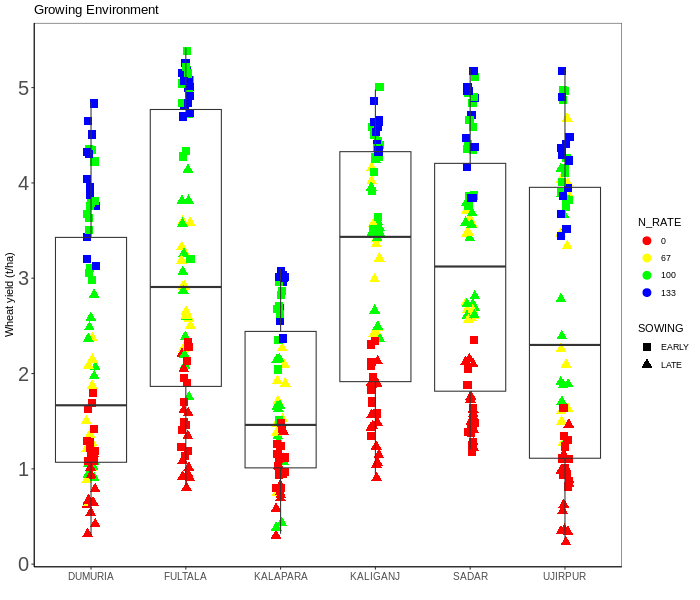

In [13]:
%%R -w 700 -h 600 -u px

cols <- c("0" = "red","67" = "yellow","100" = "green", "133" = "blue")
shap = c(15,17)

# ENV Mean

p1= ggplot(df, aes(y=GY, x=ENV)) +
         geom_point(aes(colour=N_RATE, shape=SOWING),size = I(3.5),
         position=position_jitter(width=0.05, height=0.05)) +
         geom_boxplot(fill=NA, outlier.colour=NA) +
         labs(title="Growing Environment")+
         xlab("") + ylab("Wheat yield (t/ha)") +
         theme_bw() +
            theme(axis.line = element_line(colour = "black"),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.y=element_text(size=20),
            axis.text.x = element_text(size=10)) +
     scale_colour_manual(values = cols) +
     scale_shape_manual(values = shap)

p1

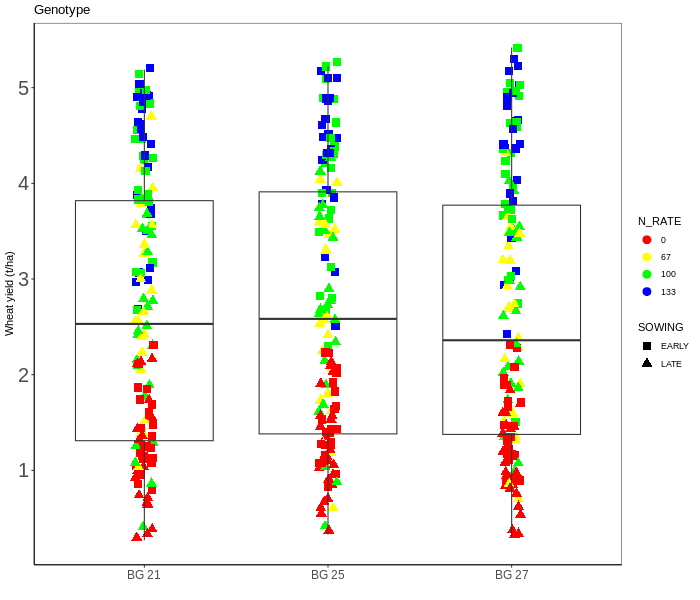

In [14]:
%%R -w 700 -h 600 -u px
# GEN Mean

p2= ggplot(df, aes(y=GY, x=GEN)) +
         geom_point(aes(colour=N_RATE, shape=SOWING),size = I(3.5),
         position=position_jitter(width=0.05, height=0.05)) +
         geom_boxplot(fill=NA, outlier.colour=NA) +
        labs(title="Genotype")+
         xlab("") + ylab("Wheat yield (t/ha)") +
         theme_bw() +
            theme(axis.line = element_line(colour = "black"),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.y=element_text(size=20),
            axis.text.x = element_text(size=12))+
     scale_colour_manual(values = cols) +
     scale_shape_manual(values = shap)

p2

### Model Fitting

To follow the hierarchical modeling process, we'll fit the models step-by-step using the dataset. The steps will include:

-   Intercept-only model: this includes only the random intercept for the grouping variable (`ENV`).
-   Mixed effect model: adds all the fixed effects: `GEN`, `DAYS`, `N_RATE` , `Maturity`, `Weeing`and `Irrigation`.

### Using `lme4` Package

#### Intercept-Only Model

This model includes only the random intercept for the grouping variable `FARMER`. The syntax `(1 | FARMER)` specifies that we are modeling the random intercept for the grouping variable `FARMER`. We use the `lmer()` function from the {lme4} package to fit the model via `REML` or maximum likelihood estimation.



In [15]:
%%R
# Intercept-only model
m_01<- lme4::lmer(GY ~ 1 + (1 | FARMER), data = df)
# Summary of the model
summary(m_01)

Linear mixed model fit by REML ['lmerMod']
Formula: GY ~ 1 + (1 | FARMER)
   Data: df

REML criterion at convergence: 1402.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1431 -0.8755  0.2872  0.7592  1.6306 

Random effects:
 Groups   Name        Variance Std.Dev.
 FARMER   (Intercept) 0.658    0.8112  
 Residual             1.339    1.1570  
Number of obs: 422, groups:  FARMER, 48

Fixed effects:
            Estimate Std. Error t value
(Intercept)    2.632      0.130   20.25


In `lmer` models (from lme4), the `t-statistics` and `p-values` are not directly provided. Instead, you can compute `p-values` using either Satterthwaite's approximation, Kenward-Roger approximation, or parametric bootstrapping.

`lmerTest::lmer()` provides p-values for fixed effects using Satterthwaite's approximation for degrees of freedom.

In [16]:
%%R
# Intercept-only model
m_01<- lmerTest::lmer(GY ~ 1 + (1|FARMER), data = df)
# Summary of the model
jtools::summ(m_01)

MODEL INFO:
Observations: 422
Dependent Variable: GY
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 1408.10, BIC = 1420.23
Pseudo-R² (fixed effects) = 0.00
Pseudo-R² (total) = 0.33 

FIXED EFFECTS:
-------------------------------------------------------
                    Est.   S.E.   t val.    d.f.      p
----------------- ------ ------ -------- ------- ------
(Intercept)         2.63   0.13    20.25   47.03   0.00
-------------------------------------------------------

p values calculated using Satterthwaite d.f.

RANDOM EFFECTS:
------------------------------------
  Group      Parameter    Std. Dev. 
---------- ------------- -----------
  FARMER    (Intercept)     0.81    
 Residual                   1.16    
------------------------------------

Grouping variables:
--------------------------
 Group    # groups   ICC  
-------- ---------- ------
 FARMER      48      0.33 
--------------------------


#### Mixed-Effects Model

Mixed-effects model includes all the fixed effects: `GEN*ENV`, `DAYS`, `N_RATE` , `Maturity_days` + `Weeding`, `Irrigation` and the random intercept for the grouping variable `FARMER`. The syntax `(1 | FARMER)` specifies that we are modeling the random intercept for the grouping variable `ENV`.


In [17]:
%%R
# Mixed effects model
m_02<- lmerTest::lmer(GY ~ GEN + ENV + DAYS+ N_RATE + Maturity_days + Weeding + Irrigation + (1 | FARMER), data = df)
# Summary of the model
jtools::summ(m_02)

MODEL INFO:
Observations: 422
Dependent Variable: GY
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 731.57, BIC = 808.43
Pseudo-R² (fixed effects) = 0.82
Pseudo-R² (total) = 0.89 

FIXED EFFECTS:
-----------------------------------------------------------
                       Est.   S.E.   t val.     d.f.      p
------------------- ------- ------ -------- -------- ------
(Intercept)            3.22   1.98     1.63   206.56   0.11
GENBG 25               0.03   0.06     0.55   402.97   0.58
GENBG 27               0.01   0.06     0.10   372.85   0.92
ENVFULTALA             0.87   0.22     4.01    41.08   0.00
ENVKALAPARA           -0.18   0.31    -0.60    56.13   0.55
ENVKALIGANJ            0.56   0.22     2.52    41.74   0.02
ENVSADAR               0.75   0.22     3.42    43.25   0.00
ENVUJIRPUR             0.51   0.23     2.20    50.25   0.03
DAYS                  -0.05   0.01    -4.16   138.86   0.00
N_RATE67               1.66   0.10    16.59   403.97   0.00
N_RATE100     

#### Mixed-Effects Model with Cross Level Interaction

We can add a cross-level interaction between `GEN` and `ENV` to the model to account for the interaction effect between the genotype and the growing environment.

In [18]:
%%R
# Mixed effects model
m_03<- lmerTest::lmer(GY ~ GEN + ENV + DAYS+ N_RATE + Maturity_days + Weeding + Irrigation + GEN:ENV+(1 | FARMER), data = df)
# Summary of the model
jtools::summ(m_03)

MODEL INFO:
Observations: 422
Dependent Variable: GY
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 767.72, BIC = 885.02
Pseudo-R² (fixed effects) = 0.81
Pseudo-R² (total) = 0.89 

FIXED EFFECTS:
------------------------------------------------------------------
                              Est.   S.E.   t val.     d.f.      p
-------------------------- ------- ------ -------- -------- ------
(Intercept)                   4.39   2.17     2.03   161.54   0.04
GENBG 25                     -0.07   0.14    -0.45   381.68   0.65
GENBG 27                      0.01   0.14     0.08   361.06   0.94
ENVFULTALA                    0.80   0.24     3.26    65.18   0.00
ENVKALAPARA                  -0.13   0.33    -0.38    72.30   0.70
ENVKALIGANJ                   0.56   0.25     2.24    65.46   0.03
ENVSADAR                      0.74   0.25     3.00    68.03   0.00
ENVUJIRPUR                    0.49   0.26     1.90    74.96   0.06
DAYS                         -0.05   0.01    -4.34   120.

#### Crossed Random Effects Model

A cross-random effects model is a type of mixed-effects model designed to handle situations where observations are influenced by two or more unrelated (crossed) grouping factors. Unlike hierarchical or nested data (e.g., students nested within schools), crossed effects occur when groupings overlap or intersect without a clear nesting structure. Component groupings are independent and not hierarchically related.

**Random Effects**: Represents variations at different levels of the data hierarchy. In a crossed random effects model, there are multiple random effects that interact with each other.

**Crossed Structure**: Unlike a hierarchical or nested structure where one random effect is nested within another, in a crossed structure, the random effects are not nested and can appear with multiple levels of other random effects.

Here below is the example for crossed random effects model where we comsdered `FARMER` and `N_RATE` as crossed random effects.

In [19]:
%%R
# Crossed random effects model
m_04<- lmerTest::lmer(GY ~ GEN+ENV+DAYS+  Maturity_days + Weeding + Irrigation + GEN:ENV+(1|FARMER) + (1|N_RATE), data = df)
# Summary of the model
jtools::summ(m_04)

MODEL INFO:
Observations: 422
Dependent Variable: GY
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 773.98, BIC = 883.20
Pseudo-R² (fixed effects) = 0.26
Pseudo-R² (total) = 0.89 

FIXED EFFECTS:
------------------------------------------------------------------
                              Est.   S.E.   t val.     d.f.      p
-------------------------- ------- ------ -------- -------- ------
(Intercept)                   5.79   2.26     2.56   152.81   0.01
GENBG 25                     -0.06   0.14    -0.44   381.77   0.66
GENBG 27                      0.01   0.14     0.07   361.15   0.94
ENVFULTALA                    0.80   0.24     3.26    65.14   0.00
ENVKALAPARA                  -0.14   0.33    -0.42    72.26   0.68
ENVKALIGANJ                   0.55   0.25     2.23    65.41   0.03
ENVSADAR                      0.74   0.25     2.98    67.98   0.00
ENVUJIRPUR                    0.49   0.26     1.89    74.91   0.06
DAYS                         -0.05   0.01    -4.30   120.

#### Nested Random Effects Model

A nested random effects model is a type of mixed-effects model designed to handle situations where observations are influenced by two or more nested grouping factors. In nested structures, one grouping factor (e.g., schools) contains the other (e.g., students), creating a hierarchical relationship.

In [20]:
%%R
# Nested  random effects model
m_05<- lmerTest::lmer(GY ~ GEN+ENV+DAYS+  Maturity_days + N_RATE +Weeding + Irrigation + GEN:ENV+ (1|ENV/FARMER), data = df)
# Summary of the model
jtools::summ(m_05)

MODEL INFO:
Observations: 422
Dependent Variable: GY
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 770.65, BIC = 892.00
Pseudo-R² (fixed effects) = 0.77
Pseudo-R² (total) = 0.90 

FIXED EFFECTS:
------------------------------------------------------------------
                              Est.   S.E.   t val.     d.f.      p
-------------------------- ------- ------ -------- -------- ------
(Intercept)                   4.45   2.27     1.96     0.00   1.00
GENBG 25                     -0.07   0.14    -0.46   386.18   0.64
GENBG 27                      0.01   0.14     0.08   365.50   0.93
ENVFULTALA                    0.81   0.47     1.73     0.00   1.00
ENVKALAPARA                  -0.13   0.53    -0.25     0.00   1.00
ENVKALIGANJ                   0.55   0.47     1.18     0.00   1.00
ENVSADAR                      0.74   0.47     1.59     0.00   1.00
ENVUJIRPUR                    0.49   0.47     1.04     0.00   1.00
DAYS                         -0.05   0.01    -4.13   102.

#### Model Comparison

To assess model improvement, compare models using information criteria such as AIC or likelihood ratio tests.

To compare the two models, we can use the `anova()` function to perform Likelihood ratio tests

In [21]:
%%R
anova(m_01, m_02, m_03, m_04,m_05)

Data: df
Models:
m_01: GY ~ 1 + (1 | FARMER)
m_02: GY ~ GEN + ENV + DAYS + N_RATE + Maturity_days + Weeding + Irrigation + (1 | FARMER)
m_04: GY ~ GEN + ENV + DAYS + Maturity_days + Weeding + Irrigation + GEN:ENV + (1 | FARMER) + (1 | N_RATE)
m_03: GY ~ GEN + ENV + DAYS + N_RATE + Maturity_days + Weeding + Irrigation + GEN:ENV + (1 | FARMER)
m_05: GY ~ GEN + ENV + DAYS + Maturity_days + N_RATE + Weeding + Irrigation + GEN:ENV + (1 | ENV/FARMER)
     npar     AIC     BIC  logLik deviance   Chisq Df Pr(>Chisq)    
m_01    3 1405.84 1417.98 -699.92  1399.84                          
m_02   19  676.79  753.64 -319.39   638.79 761.055 16  < 2.2e-16 ***
m_04   27  715.77  824.99 -330.89   661.77   0.000  8          1    
m_03   29  694.02  811.32 -318.01   636.02  25.755  2  2.555e-06 ***
m_05   30  696.02  817.37 -318.01   636.02   0.000  1          1    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [22]:
%%R
AIC(m_01, m_02, m_03, m_04, m_05)

     df       AIC
m_01  3 1408.0976
m_02 19  731.5747
m_03 29  767.7177
m_04 27  773.9837
m_05 30  770.6451


#### Model Interpretaion

We can use {report} package to generate a comprehensive report of the model output.

In [23]:
%%R
report::report(m_02)

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict GY with GEN, ENV, DAYS, N_RATE, Maturity_days, Weeding and
Irrigation (formula: GY ~ GEN + ENV + DAYS + N_RATE + Maturity_days + Weeding +
Irrigation). The model included FARMER as random effect (formula: ~1 | FARMER).
The model's total explanatory power is substantial (conditional R2 = 0.89) and
the part related to the fixed effects alone (marginal R2) is of 0.82. The
model's intercept, corresponding to GEN = BG 21, ENV = DUMURIA, DAYS = 0,
N_RATE = 0, Maturity_days = 0, Weeding = 0 and Irrigation = 1, is at 3.22 (95%
CI [-0.67, 7.10], t(403) = 1.63, p = 0.104). Within this model:

  - The effect of GEN [BG 25] is statistically non-significant and positive (beta
= 0.03, 95% CI [-0.09, 0.16], t(403) = 0.55, p = 0.583; Std. beta = 0.02, 95%
CI [-0.06, 0.11])
  - The effect of GEN [BG 27] is statistically non-significant and positive (beta
= 5.41e-03, 95% CI [-0.11, 0.12], t(403) = 0.10, p = 0.924; S

#### Model Performance

Model performance can be assessed using metrics such as Marginal $R^2$ and Conditional $R^2$.

In [24]:
%%R -
performance::model_performance(m_02)

        AIC      AICc       BIC R2_conditional R2_marginal        ICC
1 -731.5747 -733.4653 -808.4298     -0.8904958  -0.8150426 -0.4079489
        RMSE      Sigma
1 -0.4423988 -0.4715591


Marginal $R^2$ and Conditional $R^2$ are two measures used to assess the goodness-of-fit of multilevel (mixed-effects) models. These measures help determine how much of the variance in the response variable is explained by the fixed effects and the combination of fixed and random effects, respectively.

**Marginal** $R^2$ represents the proportion of variance in the response variable that is explained **only by the fixed effects** in the model. Shows the explanatory power of the fixed predictors (e.g., variables like `GEN`, `DAYS`, `N_RATE` , `Maturity_days` + `Weeding`, `Irrigation` in your model).

**Conditional** $R^2$ represents the proportion of variance in the response variable that is explained by **both fixed and random effects** in the models. It reflects the combined explanatory power of the fixed predictors and the hierarchical structure (random effects).

Total Variance ($\sigma^2_{\text{total}}$) = Variance explained by fixed effects ($\sigma^2_{\text{fixed}}$) + Variance explained by random effects ($\sigma^2_{\text{random}}$) + Residual variance ($\sigma^2_{\text{residual}}$).

$$ R^2_{\text{marginal}} = \frac{\sigma^2_{\text{fixed}}}{\sigma^2_{\text{total}}} $$

$$ R^2_{\text{conditional}} = \frac{\sigma^2_{\text{fixed}} + \sigma^2_{\text{random}}}{\sigma^2_{\text{total}}} $$

#### Visualize Random Effects

`sjPlot::plot_model()` function can be used to visualize random effects.



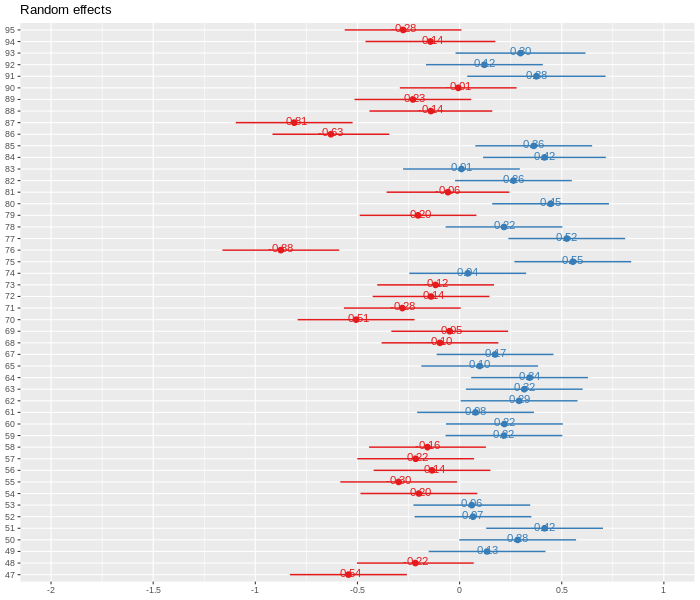

In [25]:
%%R -w 700 -h 600 -u px
# Visualize random effects
sjPlot::plot_model(m_02, type = "re", show.values = TRUE)

The values you see are NOT actual values, but rather the difference between the general intercept or slope value found in your model summary and the estimate for this specific level of random effect.

#### Marginal Effects and Adjusted Predictions

If we want the marginal effects for "N_RATE", you may use `margins()` function of {margins} package:

In [26]:
%%R
margins::margins(m_02, variables = "N_RATE")

 N_RATE67 N_RATE100 N_RATE133
    1.663     1.937     2.422


{ggeffects} package supports labelled data and the `plot()` method automatically sets titles, axis - and legend-labels depending on the value and variable labels of the data.

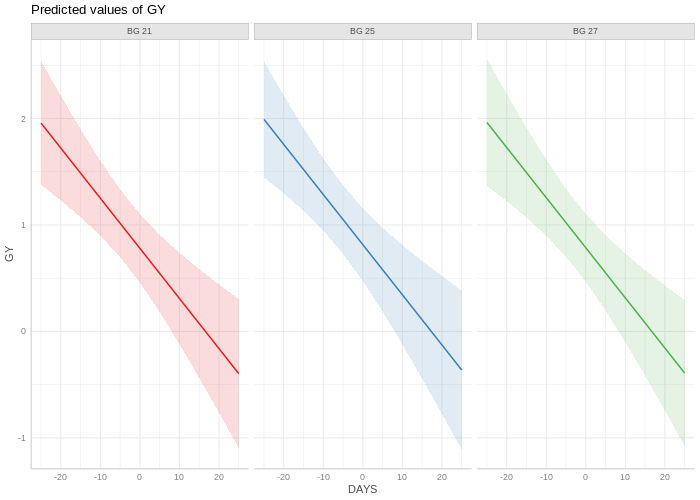

In [28]:
%%R -w 700 -h 500 -u px
# Plot the marginal effects
plot(ggeffects::predict_response(m_02, terms = c("DAYS", "GEN")), facets = TRUE)


#### Cross-validation

To perform cross-validation for the full model and evaluate its performance, we can use techniques such as k-fold cross-validation. Here, we split the data into `k` folds, train the model on `k-1` folds, and evaluate it on the remaining fold. We repeat this process `k` times, each time with a different fold held out for testing.


In [35]:
%%R

n<-length(df$GY)
k <- 5  # Number of folds
folds <- cut(seq(1, n), breaks = k, labels = FALSE)

# Initialize lists to store results
results <- list()
rmse_values <- c()
# Cross-validation loop
for (i in seq_along(folds)) {
  # Split data into training and testing sets
  train_data <- df[-folds[[i]], ]
  test_data <- df[folds[[i]], ]

  # Fit the full model on training data
  model <- lmerTest::lmer(GY ~ GEN+ENV+DAYS+Maturity_days + N_RATE +Weeding + Irrigation + (1|FARMER), data = train_data)

  # Predict on test data
  predictions <- predict(model, newdata = test_data, allow.new.levels = TRUE)

  # Calculate evaluation metrics
  rmse <- MLmetrics::RMSE(predictions, test_data$GY)
  # Store results
  rmse_values <- c(rmse_values, rmse)
}

In [36]:
%%R
# Summarize RMSE and R-squared
mean_rmse <- mean(rmse_values)
sd_rmse <- sd(rmse_values)

# Print performance
cat("Cross-Validation Results:\n")
cat("Mean RMSE:", mean_rmse, "±", sd_rmse, "\n")

Cross-Validation Results:
Mean RMSE: 0.772124 ± 0.3546553 


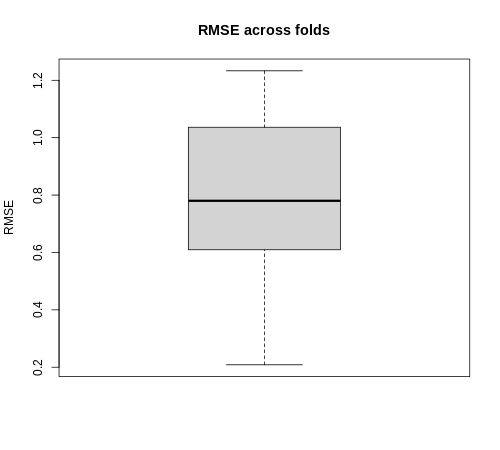

In [37]:
%%R -w 500 -h 450 -u px
# Plot RMSE values
boxplot(rmse_values, main = "RMSE across folds", ylab = "RMSE")

### Using `nlme` Package

`lme()` function of {nlme} package is used to fit linear mixed-effects models. The syntax `(1 | ENV)` specifies that we are modeling the random intercept for the grouping variable `ENV`.

In [38]:
%%R
# Full model
model_full_nlme <- nlme::lme(fixed = GY ~ GEN+ENV + DAYS+ N_RATE + Maturity_days + Weeding + Irrigation,
                        random = ~ 1 | FARMER, data = df)

# Summary of the model
summary(model_full_nlme)

Linear mixed-effects model fit by REML
  Data: df 
       AIC      BIC    logLik
  731.5747 807.6486 -346.7874

Random effects:
 Formula: ~1 | FARMER
        (Intercept)  Residual
StdDev:   0.3914348 0.4715591

Fixed effects:  GY ~ GEN + ENV + DAYS + N_RATE + Maturity_days + Weeding + Irrigation 
                  Value Std.Error  DF   t-value p-value
(Intercept)    3.215360 1.9754016 365  1.627700  0.1045
GENBG 25       0.034703 0.0630947 365  0.550019  0.5826
GENBG 27       0.005414 0.0567474 365  0.095407  0.9240
ENVFULTALA     0.871707 0.2172221  40  4.012976  0.0003
ENVKALAPARA   -0.182924 0.3070499  40 -0.595747  0.5547
ENVKALIGANJ    0.555312 0.2204178  40  2.519360  0.0159
ENVSADAR       0.751582 0.2199770  40  3.416638  0.0015
ENVUJIRPUR     0.511433 0.2322791  40  2.201805  0.0335
DAYS          -0.047093 0.0113234  40 -4.158851  0.0002
N_RATE67       1.662902 0.1002650 365 16.585078  0.0000
N_RATE100      1.937429 0.0851462 365 22.754149  0.0000
N_RATE133      2.421983 0.0966

In [39]:
%%R
performance(model_full_nlme)


# Indices of model performance

AIC     |    AICc |     BIC | R2 (cond.) | R2 (marg.) |   ICC |  RMSE | Sigma
-----------------------------------------------------------------------------
731.575 | 733.465 | 808.430 |      0.890 |      0.815 | 0.408 | 0.442 | 0.472


## Summary and Concusion

In this tutorial, we explored the construction, implementation, and evaluation of Random Intercept Models using R. These are essential tools in mixed-effects modeling, enabling us to analyze hierarchical or grouped data by accounting for fixed and random effects. They effectively capture group-level variability, making them powerful for analyzing hierarchical data.

Acquiring these skills is crucial for accurately analyzing complex data structures and making robust inferences about predictors and their effects. With this foundation, you can apply Random Intercept Models to your datasets and delve into more advanced multilevel modeling techniques, such as random slopes and cross-level interactions.

## References

### Books:
1. **"Multilevel and Longitudinal Modeling Using R" by Douglas A. Luke**
   - This book provides a practical guide to the use of multilevel modeling in applied research, covering both the theory and application of multilevel modeling techniques using R.

2. **"Multilevel Analysis: Techniques and Applications" by Joop Hox**
   - This book is an introduction to multilevel analysis, focusing on the practical application of multilevel modeling techniques using R.

3. **"Hierarchical Linear Models: Applications and Data Analysis Methods" by Stephen W. Raudenbush and Anthony S. Bryk**
   - This book provides a comprehensive introduction to hierarchical linear modeling (HLM) and its applications, including examples and applications in R.

4. **"Applied Multilevel Analysis" by Jos Twisk**
   - This book is a practical guide to the use of multilevel analysis in applied research, covering both the theory and application of multilevel modeling techniques using R.

5. **"Generalized Linear Mixed Models: Modern Concepts, Methods and Applications" by Charles E. McCulloch, Shayle R. Searle, and John M. Neuhaus**
   - This book provides a comprehensive introduction to generalized linear mixed models, including random intercept models, with practical examples in R.

### Online Tutorials:
1. **"Multilevel Modeling in R" by UCLA Institute for Digital Research and Education**
   - URL: [UCLA IDRE Guide](https://stats.idre.ucla.edu/r/seminars/r-multilevel-models/)
   - This tutorial provides an introduction to multilevel modeling in R, including examples and code.

2. **"Random Intercept and Random Slope Models in R" by DataCamp**
   - URL: [DataCamp Guide](https://www.datacamp.com/community/tutorials/random-intercept-random-slope-models-r)
   - This tutorial covers the basics of random intercept and random slope models in R, including practical examples using the lme4 package.

3. **"Linear Mixed-Effects Modeling in R: A Step-by-Step Tutorial" by Towards Data Science**
   - URL: [Towards Data Science Tutorial](https://towardsdatascience.com/linear-mixed-effects-modeling-in-r-61b9f845f623)
   - This tutorial provides a step-by-step guide to linear mixed-effects modeling in R, with practical examples and code.

4. **"An Introduction to Mixed Models in R" by the University of Virginia Library Research Data Services + Sciences**
   - URL: [UVA Library Guide](https://data.library.virginia.edu/getting-started-with-mixed-effects-models-in-r/)
   - This tutorial provides an introductory guide to mixed models in R, covering both theory and practical examples.

5. **"Mixed Models in R Using the lme4 Package: Part 1" by R-bloggers**
   - URL: [R-bloggers Tutorial](https://www.r-bloggers.com/2020/02/mixed-models-in-r-using-the-lme4-package-part-1/)
   - This tutorial provides an introduction to mixed models in R using the lme4 package, with a focus on random intercept models.



